In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import scipy.stats
plt.style.use("customstyle")

from statsmodels.stats.multitest import multipletests


colors = ["#" + x for x in ["000000","cf5c36","bcd696","985f99","9684a1"]]
lcolors = ["#" + x for x in ["000000","e7af9c","cfb4d0","cec5d3"]] # light colors (for fill)

In [2]:
def stars_pvalue(p):
    if p <= 0.001:
        return '***'
    if p <= 0.01:
        return '**'
    if p <= 0.05:
        return '*'
    return 'ns'

width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)

In [3]:
# Load inference data
outdir = "C:/Users/pveron/Output_clusters/PBD_analog/12152"

simul_infer = pd.read_csv(outdir + "/all_simulations_inference.csv")
simul_infer["combinaison"] = 10*simul_infer.param_vary + simul_infer.i_param_var

summary_all_mcmc = pd.read_csv(outdir + "/summary_all_MCMC.csv")

n_rep = 1 + max(simul_infer.replicate)
n_val = max(simul_infer.i_param_var)
n_par = 5 
tree_stats = pd.read_csv(outdir + "/strees_stats.csv")

simBD_tree_stats = pd.read_csv(outdir + "/simulated_BD_trees_stats.csv")

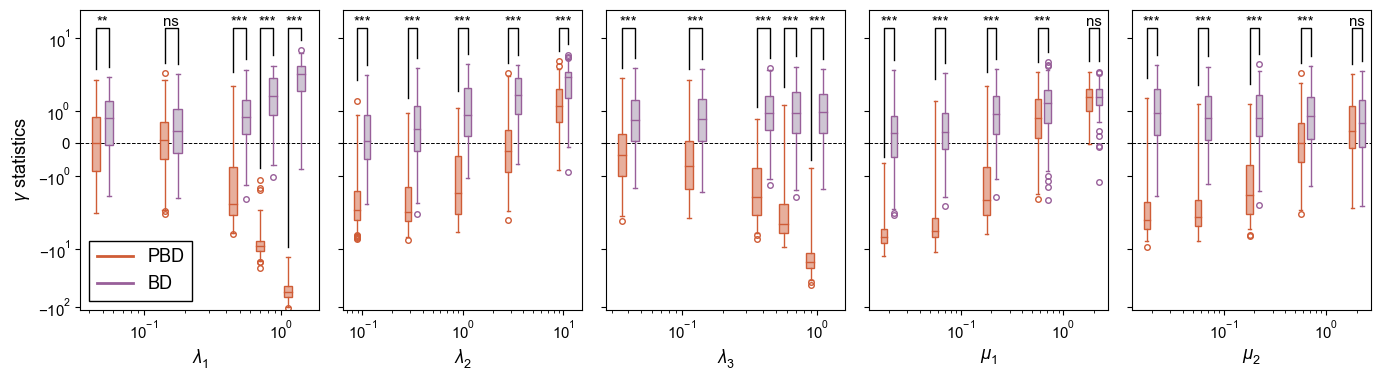

In [4]:
PBD_names = ["PBD." + s for s in ["l1", "l2", "l3", "mu1", "mu2"]]

fig, axes = plt.subplots(1, 5, figsize = (14,4), sharey = True)

# Define boxplot styles 
c, lc = colors[1], lcolors[1] # for PBD boxplots
p = dict(color = c)
bp_stl_pbd = dict(capprops = p, boxprops = dict(edgecolor = c, facecolor = lc), 
                  flierprops = dict(markeredgecolor = c, markersize = 4), 
                  medianprops = p, whiskerprops = p, patch_artist = True)

c, lc = colors[3], lcolors[3] # for BD boxplots
p = dict(color = c)
bp_stl_bd = dict(capprops = p, boxprops = dict(edgecolor = c, facecolor = lc), 
                  flierprops = dict(markeredgecolor = c, markersize = 4), 
                  medianprops = p, whiskerprops = p, patch_artist = True)

w = 0.06 # width of the boxplots
d = np.exp(0.11) # distance between boxplots (in log scale)

# Statistical tests
all_pvals = np.zeros((n_par, n_val))
all_mwu = np.zeros((n_par, n_val)) # Mann-Whitney U tests
n_trees = np.zeros((n_par, n_val, 2)) # Store the number of trees 

positions = np.zeros((n_par,n_val)) # x positions of the plots
maxval = np.zeros((n_par,n_val,2)) # maximum of gamma maxval[i_par, i_val, j] with j = 0 for PBD | 1 for BD

for i_par in range(n_par):
    axes[i_par].axhline(0, color = "k", lw = 0.7, ls = "--")

    boxes = [] # store the boxes data
    boxes_bd = []
    for i_val in range(n_val):
        # select the corresponding lines in the different dataframes 
        params = simul_infer.loc[(simul_infer.param_vary == i_par + 1) & 
                                 (simul_infer.i_param_var == i_val + 1) &
                                 (simul_infer.replicate == 0), PBD_names].to_dict("records")[0]
        tree_stats_config = tree_stats.loc[(tree_stats.param_vary == i_par + 1) & 
                                           (tree_stats.i_param_var == i_val + 1)]
        bd_stats_config = simBD_tree_stats.loc[(simBD_tree_stats.param_vary == i_par+1) & 
                                               (simBD_tree_stats.i_param_var == i_val + 1 )]
        
        positions[i_par, i_val] = params[PBD_names[i_par]]

        gamma = tree_stats_config.gamma
        gamma = gamma.loc[(np.isfinite(gamma))] # remove nan
        maxval[i_par, i_val, 0] = np.max(gamma)

        gamma_bd = bd_stats_config.gamma
        gamma_bd = gamma_bd.loc[(np.isfinite(gamma_bd))] # remove nan
        maxval[i_par, i_val, 1] = np.max(gamma_bd)

        n_trees[i_par, i_val, :] = (len(gamma), len(gamma_bd))

        mwu = scipy.stats.mannwhitneyu(gamma, gamma_bd) # Mann-Whitney U test
        all_mwu[i_par, i_val] = mwu.statistic
        all_pvals[i_par, i_val] = mwu.pvalue
        
        boxes.append(boxplot_stats(gamma, labels = None)[0])
        boxes_bd.append(boxplot_stats(gamma_bd, labels = None)[0])
    
    # Draw boxplots
    x = positions[i_par, :]
    bxp = axes[i_par].bxp(boxes, positions = x / d, widths = width(x / d, w), **bp_stl_pbd)
    bxp = axes[i_par].bxp(boxes_bd, positions = x * d, widths = width(x * d, w), **bp_stl_bd)

# Bonferroni correction for multiple test
bonferroni = multipletests(all_pvals.flatten(), method = "bonferroni")
p_vals_corrected = np.reshape(bonferroni[1], newshape= all_pvals.shape)

# Set ylim
ylim_lock = (-110, 30)

# Legend
axes[0].plot([],[], lw = 2, label = "PBD", color = bp_stl_pbd["whiskerprops"]["color"])
axes[0].plot([],[], lw = 2, label = "BD", color = bp_stl_bd["whiskerprops"]["color"])
axes[0].legend()

# Add pvalues to the graph
caphi = 15 # Position of the upper cap for the signif. bars 
def symlog_d(y): # transform to have a dy constant in symlog scale
    if y > 0:
        return y * 1.5
    return y / 1.5

for i_par in range(5):
    for i_val in range(5):
        axes[i_par].text(x = positions[i_par, i_val], y = caphi*1.05, 
                         s = stars_pvalue(p_vals_corrected[i_par, i_val]),
                         ha = "center", size = 'small')

        # signif bars
        x = [positions[i_par, i_val] / d] * 2 + [positions[i_par, i_val] * d] * 2
        y = [symlog_d(maxval[i_par, i_val, 0]),caphi,caphi, symlog_d(maxval[i_par, i_val, 1])]
        axes[i_par].plot(x, y, lw = 1, color = "k")

    axes[i_par].set_xscale("log")

axes[0].set_xlabel("$\lambda_1$")
axes[1].set_xlabel("$\lambda_2$")
axes[2].set_xlabel("$\lambda_3$")
axes[3].set_xlabel("$\mu_1$")
axes[4].set_xlabel("$\mu_2$")

axes[0].set_ylabel("$\gamma$ statistics")
axes[0].set_yscale("symlog")
axes[0].set_ylim(ylim_lock)

plt.savefig("../../fig/CBD_gamma_vs_BD_gamma.pdf")

# Save the results of the MannWhitney_U_test
df = pd.DataFrame.from_dict(dict(param_vary = np.repeat(np.arange(1, 1+n_par), n_val), 
                                 i_param_var = np.tile(np.arange(1, 1+n_val), n_par),
                                 n_trees_pbd = n_trees[:,:,0].flatten(),
                                 n_trees_bd = n_trees[:,:,1].flatten(), 
                                 statistics = all_mwu.flatten(), 
                                 p_value = all_pvals.flatten(), 
                                 corrected_p_value = p_vals_corrected.flatten()))
df.to_csv("Gamma_PBD_BD_MannWhitney_U_test.csv");